#### О том как можно реализовать стекинг...

в этом туторе рассмотрена техника ансамблирования моделей - стекинг и блендинг с технической стороны. 

коротко о том, что я под этим подразумеваю:

Стекинг - когда мы на данных обучаем несколько различных моделей, а потом на их предсказаниях обучаем еще одну и берем ее ответы.

Блендинг - просто взвешенная сумма ответов нескольких различных моделей.


In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score


In [2]:
# итак считаем какие-то данные
dt = pd.read_csv('log_data.csv', header=None, names=['target', 'x1', 'x2'])

In [3]:
dt.head()

,target,x1,x2
0,-1,-0.663827,-0.138526
1,1,1.994596,2.468025
2,-1,-1.247395,0.749425
3,1,2.309374,1.899836
4,1,0.849143,2.407750


In [4]:
X = dt[['x1','x2']].values
y = dt['target'].values

In [5]:
# разделим на трейн и тест 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify = y)

In [6]:
# зададим  разбиение и не будем его менять
skf = StratifiedKFold(y, n_folds=6, random_state=0)

ok!

мы сказали, что нам как то нужно обучить наши модели на первом уровне, а потом предсказания объединить в матрицу и на них обучить еще одну модель.

Все круто, но хотелось бы использовать все данные которые есть для обучения моделей первого уровня, при этом обучить и получить их предсказания честно. Для этого поступим следующим образом. 

(снизу рисунок получения данных для одной модели первого уровня)

- Зафиксируем разбиение
- Кросс-валидацией будем обучать модель и предсказывать на оставшейся части данных вероятности (можно и ответы)
    * при этом будем соблюдать чтобы на выходе получился вектор ответов и ответы совпадали с данными для которых предсказывали (это сделано для того чтобы можно было обучить модель второго уровня с тем же вектором таргета)
    * после того как получили данные для обучения модели второго уровня, можно обучать на всех данных модели первого уровня (без кросс-валидации взять и обучить!)
- Взять ответы и тот же таргет и на них обучить поверх еще одну модель.

+++ предсказания:

- предсказываем ответы моделей первого уровня.
- в том же порядке стакаем матрицу и получаем предсказания с модели второго уровня - - - это и есть финальный ответ

![okey](excelcvpp.png)

### как мы можем получать такую матричку для моделек первого уровня?

#### способ 1

In [7]:
def cross_val_predict_proba(estimator, skf, X, y):
    """
    выдает вектор заполненный так: учимся на N-1 фолдах, предсказываем на 1, заполняем вероятности 
    ровно тех индексов, на которых предсказывали. берем другие N-1 фолдов и тд... и так пока не пройдем все
    """
    res = np.zeros(y.shape)
    for train, test in skf:
        estimator.fit(X[train], y[train])
        res[test] = estimator.predict_proba(X[test])
    return res

In [8]:
### эти ответы со всех моделей первого уровня можно склеить (застакать) вот так
a = np.array([1,1,1,1,1,1])
b = np.array([0,0,0,1,1,1])
c = np.array([1,1,1,0,0,0])

d = np.vstack([a,b,c]).T

In [9]:
d

array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]])

#### ну или способ 2.

заделаем класс-обертку в который завернем свой классификатор

зачем?

чтобы честно заполнять предсказания с перового уровня с помощью функции cross_val_predict (и не пилить свое cross_val_predict_proba):
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_predict.html


In [10]:
from sklearn.base import BaseEstimator

# то есть создадим класс обертку который будет выдавать только вероятности (даже когда будем просить ответы!)
class Only_proba_classifier(BaseEstimator):
    def __init__(self, clf):
        self.clf = clf
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
    
    def predict(self, X):
        return self.clf.predict_proba(X)
    
    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Тогда он будет работать вот так:

cross_val_predict(Only_proba_classifier(clf), X, y, cv=skf)

но с разных моделей стакать (склеивать) результаты все равно придется руками.

### Перейдем к делу взяв способ номер 2

In [11]:
# возьмем RandomForest в качестве одного из классификаторов

clf_rf = RandomForestClassifier(random_state=0)

# заполним матрицу предсказаний вероятностями 
preds_rf = cross_val_predict(Only_proba_classifier(clf_rf), X, y, cv=skf) 

# обучим модель на всех данных
clf_rf.fit(X, y)


### сразу сделаем предсказания для теста.
preds_test_rf = clf_rf.predict_proba(X_test)

In [12]:
# возьмем LogisticRegression в качестве другого классификатора
sc = MinMaxScaler()
clf_lr = LogisticRegression(random_state=0)

# заполним матрицу предсказаний вероятностями
preds_lr = cross_val_predict(Only_proba_classifier(clf_lr), sc.fit_transform(X), y, cv=skf)


# обучим модель на всех данных
clf_lr.fit(sc.transform(X), y)


### сразу сделаем предсказания для теста.
preds_test_lr = clf_lr.predict_proba(sc.transform(X_test))

In [13]:
### результаты с кроссвалидации

print ('Random Forest: {0:0.3f}'.format(roc_auc_score(y, preds_rf[:, 1])))
print ('Logistic Regression: {0:0.3f}'.format(roc_auc_score(y, preds_lr[:, 1])))

Random Forest: 0.933
Logistic Regression: 0.888


In [14]:
### на тесте 
print ('Random Forest test: {0:0.3f}'.format(roc_auc_score(y_test, preds_test_rf[:, 1])))
print ('Logistic Regression test: {0:0.3f}'.format(roc_auc_score(y_test, preds_test_lr[:, 1])))

Random Forest test: 0.961
Logistic Regression test: 0.931


____

Итак Blending

Говорят - это просто взвешенная сумма предсказаний (можно подбирать перебором, можно на глаз, можно опираться
на предсказательную силу классификатора или на лидерборд)

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

Best roc auc score: 0.948
Best alpha: 0.717


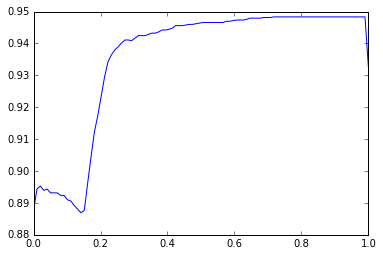

In [16]:
weights = np.linspace(0, 1, 100)
scores = np.zeros_like(weights)

for index, alpha in enumerate(weights):
    preds = alpha * preds_rf + (1-alpha) * preds_lr
    score = roc_auc_score(y, preds[:, 1])
    scores[index] = score

plt.plot(weights, scores)
print ('Best roc auc score: {0:0.3f}'.format(scores.max()))
print ('Best alpha: {0:0.3f}'.format(weights[scores.argmax()]))

In [17]:
alpha = 0.717

final_blending_prediction = alpha * preds_test_rf + (1-alpha) * preds_test_lr

In [18]:
print ('Blending on test: {0:0.3f}'.format( roc_auc_score(y_test, final_blending_prediction[:, 1]) ))

Blending on test: 0.973


_____

еще есть стекинг __stacking__

тут мы второй моделью взвешиваем результаты первых

In [19]:
### склеиваем данные для трейна и теста  соответственно
train_stacking = np.hstack([preds_rf, preds_lr])
test_stacking = np.hstack([preds_test_rf, preds_test_lr])

возьмем моделью второго уровня - логрегрессию:

In [21]:
lr_stacking = LogisticRegression()
lr_stacking.fit(train_stacking, y)
print ('stacking train: {0:0.3f}'.format(roc_auc_score(y,    lr_stacking.predict_proba(train_stacking)[:,1] )))
print ('stacking test: {0:0.3f}'.format(roc_auc_score(y_test, lr_stacking.predict_proba(test_stacking)[:,1] )))

stacking train: 0.948
stacking test: 0.973


In [27]:
# попробуем потюнить
lr_stacking = LogisticRegression(C=1e-4, fit_intercept=False)
lr_stacking.fit(train_stacking, y)
print ('stacking optimizing train: {0:0.3f}'.format(roc_auc_score(y,    lr_stacking.predict_proba(train_stacking)[:,1] )))
print ('stacking optimizing test: {0:0.3f}'.format(roc_auc_score(y_test, lr_stacking.predict_proba(test_stacking)[:,1] )))

stacking optimizing train: 0.949
stacking optimizing test: 0.972
